# RandomForest를 활용한 자전거 대여량 예측하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

In [2]:
from tensorflow.keras import datasets, layers, models

In [3]:
path = "data/"
print(os.listdir("data/"))

['sampleSubmission.csv', 'test.csv', 'train.csv']


# load data

In [4]:
df_train_eda = pd.read_csv(path + "train.csv", parse_dates = ['datetime'],
                         index_col='datetime', infer_datetime_format=True)
df_test = pd.read_csv(path + 'test.csv', parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True)
df_submission = pd.read_csv(path+'sampleSubmission.csv', parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True)

# Columns 

- datetime : 시간별 날짜
- season :  
  1.(1분기)  
  2.(2분기)   
  3.(3분기)  
  4.(4분기)
- holiday : 하루가 휴일로 간주되는지 여부
- workingday : 주말과 휴일이 아닌 일하는 날
- weather :   
  1.(맑음, 구름, 조금, 흐림)  
  2.(안개+흐림, 안개+구름, 안개+구름이 거의 없음 + 흐림)  
  3.(가벼운 눈, 가벼운 비 + 천둥 + 구름, 가벼운 비 + 구름)  
  4.(폭우 + 우박 + 천둥 + 안개, 눈 + 안개)
- temp : 섭씨 온도
- atemp : 섭씨 온도의 느낌
- humidity : 상대 습도
- windspeed : 풍속
- casual : 미등록 사용자 대여수
- registered : 등록된 사용자 대여수
- count : 대여수

 

In [5]:
df_train_eda.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [6]:
df_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [7]:
df_submission.head(3)

,count
datetime,
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0


# EDA

## 데이터 타입 확인

In [8]:
print(df_train_eda.shape, df_test.shape)
print("훈련 데이터")
print(df_train_eda.dtypes)
print("테스트 데이터")
print(df_test.dtypes)

(10886, 11) (6493, 8)
훈련 데이터
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object
테스트 데이터
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object


## 결측치 확인

In [9]:
print(df_train_eda.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [10]:
print(df_test.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


In [11]:
print(df_submission.isnull().sum())

count    0
dtype: int64


## datetime 에서 년,월,일,시간,분,초를 추출해 column 추가

In [12]:
df_train_eda['year'] = df_train_eda.index.year

In [13]:
df_train_eda['year'] = df_train_eda.index.year
df_train_eda['month'] = df_train_eda.index.month
df_train_eda['day'] = df_train_eda.index.day
df_train_eda['hour'] = df_train_eda.index.hour
df_train_eda['minute'] = df_train_eda.index.minute
df_train_eda['second'] = df_train_eda.index.second

In [14]:
df_train_eda.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


## 연도별, 월별,시간별에 따른 대여량 평균치 분석

In [15]:
def bar_plot(df, x, ax):
    fig = plt.figure(figsize=(5,3))
    sns.barplot(data=df, x=x, y="count", palette="Blues_d", ax=ax)

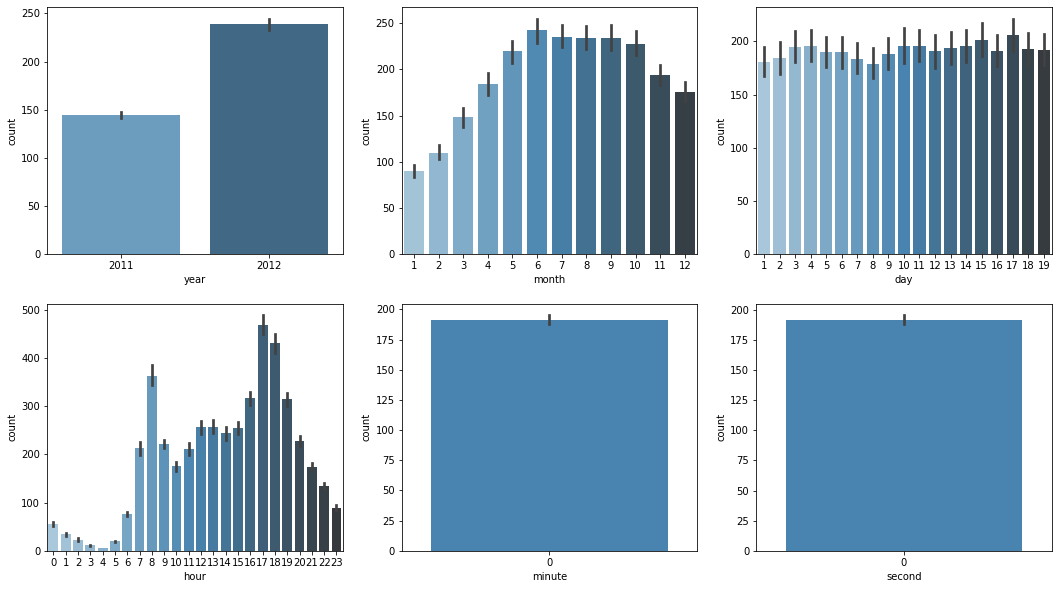

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

In [16]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 10)

bar_plot(df_train_eda, "year", ax=ax1)
bar_plot(df_train_eda, "month", ax=ax2)
bar_plot(df_train_eda, "day", ax=ax3)
bar_plot(df_train_eda, "hour", ax=ax4)
bar_plot(df_train_eda, "minute", ax=ax5)
bar_plot(df_train_eda, "second", ax=ax6)

## 연도별,월별,시간별에 따른 분석 결과

- 연도별 : 2011년보다 2012년 대여량이 많아짐  
- 월별 : 월별 대여량은 6월에 가장 많고, 따뜻한 계절(5~10월달)에 대여량이 많음
- 일별 : 일별 대여량은 크게 차이점이 없고, 특징점 역시 없음.
- 시간별 : 오전에는 8시에 가장 많고, 오후에는 17시~18시에 가장 많음

## datetime을 기반으로 요일 추출

In [17]:
df_train_eda['dayofweek'] = df_train_eda.index.dayofweek
df_train_eda.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5


## 시간대별 자전거 대여량 (근무일 유무, 요일, 시즌, 날씨)

In [18]:
def point_plot(df, hue, ax):
    sns.pointplot(data=df, x="hour", y="count", ax=ax, hue=hue)

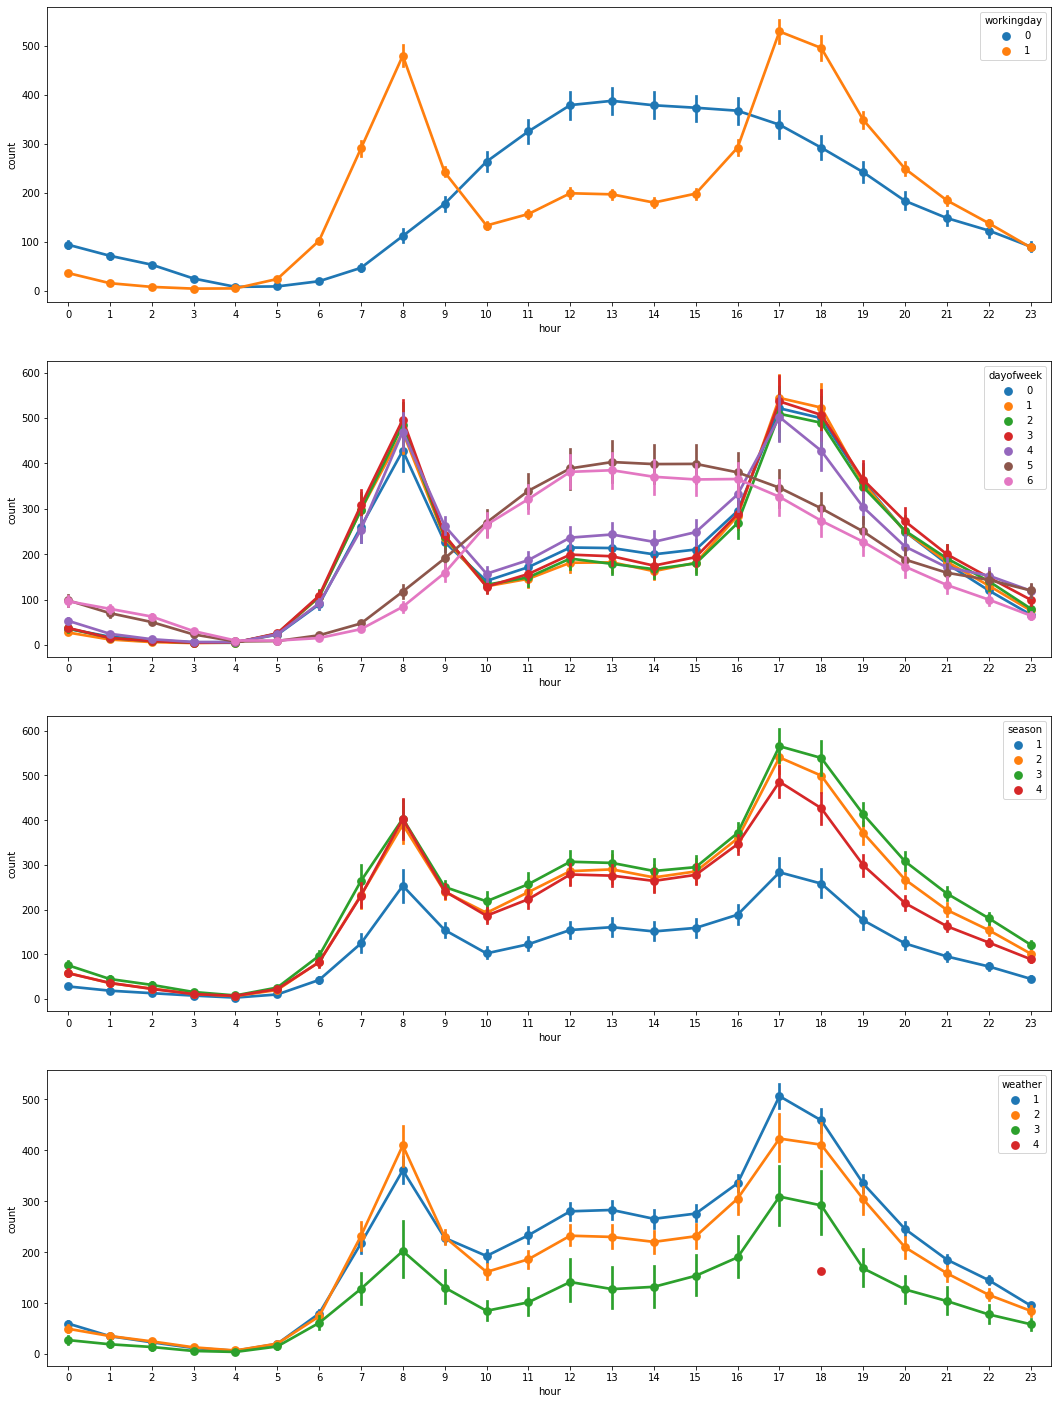

In [19]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18,25)

#sns.pointplot(df_train, ax=ax1)
point_plot(df_train_eda, 'workingday', ax=ax1)
point_plot(df_train_eda, 'dayofweek', ax=ax2)
point_plot(df_train_eda, 'season', ax=ax3)
point_plot(df_train_eda, 'weather', ax=ax4)

앞선 시간대별 자전거 대여량 그래프를 보면 오전8시, 오후 5~6시에 가장 대여량이 많았다.

근무일, 요일, 분기, 날씨에 따른 대여량에 대한 분석  
- 근무일에는 출근시간(8시), 퇴근시간(17 ~ 18시)에 가장 대여량이 높았고, 휴무일에는 12 ~ 16시에 가장 대여를 많이했다.
- 평일은 근무일 대여량, 주말은 휴무일 대여량에 따르는 것을 확인할 수 있다.
- 3분기(7 ~ 9월)에 가장 대여를 많이하고, 1분기(1 ~ 3월)에 가장 적게 대여를 하는 것을 볼 수 있다.
- 날씨가 좋을 수록 대여를 많이하고, 좋지 않을 때는 대여를 많이 안한다.

# EDA 분석 끝 다시 원본 데이터 불러오기

In [20]:
df_train = pd.read_csv(path + "train.csv", parse_dates = ['datetime'],
                       index_col='datetime', infer_datetime_format=True)

In [21]:
df_train.shape

(10886, 11)

In [22]:
df_train.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


### df_train데이터는 한 시간 단위로 2011-01-01 00:00:00  ~ 2012-12-19 23 23:00:00 ( 1일부터19일)
### 즉, 2(years) * 12(month) * 19(days) * 24(hours) =  10944(timestep)이어야한다.
### 하지만 df_train데이터는 10886(timestep) 이므로 중간에 누락된 정보가 있다.
### 따라서 (10944-10886) = 58개의 timestep을 채워야 한다.

In [23]:
num_months_per_year = 12
year_list = [2011, 2012]

In [24]:
df_train_temp = pd.DataFrame(columns=df_train.columns)

for year in year_list: # 2011 2012
    for month in range(num_months_per_year):# 0~11
        start_date = datetime.datetime(year, month+1, 1, 0, 0, 0)
        end_date = datetime.datetime(year, month+1, 19, 23, 0, 0)
        temp = df_train[start_date:end_date].resample('H').asfreq()
        df_train_temp = df_train_temp.append(temp)
        
train_data = df_train_temp

In [25]:
train_data.shape

(10944, 11)

### 채워준 timestep의 결측치를 채워야한다.

In [26]:
train_data.isna().sum()

season        58
holiday       58
workingday    58
weather       58
temp          58
atemp         58
humidity      58
windspeed     58
casual        58
registered    58
count         58
dtype: int64

In [27]:
null_feature = train_data[train_data['count'].isnull()].index
null_feature

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               '2011-01-12 04:00:00', '2011-01-14 04:00:00',
               '2011-01-18 00:00:00', '2011-01-18 01:00:00',
               '2011-01-18 02:00:00', '2011-01-18 03:00:00',
               '2011-01-18 04:00:00', '2011-01-18 05:00:00',
               '2011-01-18 06:00:00', '2011-01-18 07:00:00',
               '2011-01-18 08:00:00', '2011-01-18 09:00:00',
               '2011-01-18 10:00:00', '2011-01-18 11:00:00',
               '2011-01-19 03:00:00', '2011-02-01 04:00:00',
               '2011-02-03 04:00:00', '2011-02-04 04:00:00',
               '2011-02-09 04:00:00', '2011-02-10 03:00:00',
               '2011-02-11 03:00:00', '2011-02-11 04:00:00',
               '2011-02-

### season, holiday, workingday, weather들은 backfill로 채운다.(같은 날짜 이기 때문)

In [28]:
backfill_features = ['season', 'holiday', 'workingday', 'weather']
train_data[backfill_features] = train_data[backfill_features].fillna(method='backfill')

### temp, atemp, humidity, windspeed 들은 linear로 채운다.

In [29]:
fill_linear_features = ['temp', 'atemp', 'humidity', 'windspeed']
train_data[fill_linear_features] = train_data[fill_linear_features].interpolate(method='linear')

### 문제는 casual, registered, count들이다.
### target값과 연관된 column이기 때문에 머신러닝 기법을 활용해 채운다.
### casual, registered 들의 합은 count이기 때문에 drop한다.

In [30]:
null_df = train_data.loc[null_feature]
null_df = null_df.drop("casual",axis=1)
null_df = null_df.drop("registered",axis=1)
null_df.head() # 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
2011-01-02 05:00:00,1.0,0.0,0.0,3.0,18.040000,21.9675,85.5,16.498750,NaN
2011-01-03 02:00:00,1.0,0.0,1.0,1.0,7.653333,7.8300,45.0,27.333767,NaN
2011-01-03 03:00:00,1.0,0.0,1.0,1.0,7.106667,7.3250,46.0,26.668233,NaN
2011-01-04 03:00:00,1.0,0.0,1.0,1.0,5.740000,8.3325,63.0,7.500650,NaN
2011-01-05 03:00:00,1.0,0.0,1.0,1.0,8.200000,10.6075,61.0,10.502250,NaN


In [31]:
full_df = train_data.drop(index = null_feature)
full_df = full_df.drop("casual",axis=1)
full_df = full_df.drop("registered",axis=1)
full_df.head() 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,16.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,40.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,32.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,13.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,1.0


## EDA분석에서 시간대별 대여량에 영향이 있는  column을 갖고온다.

In [32]:
null_df['year'] = null_df.index.year
null_df['month'] = null_df.index.month
null_df['day'] = null_df.index.day
null_df['hour'] = null_df.index.hour

full_df['year'] = full_df.index.year
full_df['month'] = full_df.index.month
full_df['day'] = full_df.index.day
full_df['hour'] = full_df.index.hour

In [33]:
X = full_df.drop("count", axis=1)
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0000,2011,1,1,0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,2011,1,1,1
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,2011,1,1,2
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,2011,1,1,3
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4.0,0.0,1.0,1.0,15.58,19.695,50.0,26.0027,2012,12,19,19
2012-12-19 20:00:00,4.0,0.0,1.0,1.0,14.76,17.425,57.0,15.0013,2012,12,19,20
2012-12-19 21:00:00,4.0,0.0,1.0,1.0,13.94,15.910,61.0,15.0013,2012,12,19,21
2012-12-19 22:00:00,4.0,0.0,1.0,1.0,13.94,17.425,61.0,6.0032,2012,12,19,22


In [34]:
y = full_df["count"]
y

2011-01-01 00:00:00     16.0
2011-01-01 01:00:00     40.0
2011-01-01 02:00:00     32.0
2011-01-01 03:00:00     13.0
2011-01-01 04:00:00      1.0
                       ...  
2012-12-19 19:00:00    336.0
2012-12-19 20:00:00    241.0
2012-12-19 21:00:00    168.0
2012-12-19 22:00:00    129.0
2012-12-19 23:00:00     88.0
Name: count, Length: 10886, dtype: float64

## randomforest 학습

In [35]:
from sklearn.model_selection import train_test_split

### 데이터 split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 필요한 라이브러리

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV  # 매개변수를 자동으로 변수 설정해서 최적 찾기 위한 방법
from sklearn.model_selection import KFold  # 몇번 나눌지
from sklearn.metrics import r2_score, mean_squared_error  # SVR 모델의 예측과 실제의 결과를 확인하는 성능지표

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [38]:
seed = 2021

### random_grid 파라미터 값 설정

In [39]:
"""
# 랜덤 포레스트의 트리 수 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)] 
# 모든 분할에서 고려해야 할 기능의 수 
max_features = ['auto', ' qrt '] 
# 트리의 최대 레벨 수 
max_depth = [int(x) for x in np.linspace(10, 11, num = 11)] 
max_depth.append(None) 
# 노드를 분할하는 데 필요한 최소 샘플 수 
min_samples_split = [2, 5, 10] 
# 각 리프 노드에 필요한 최소 샘플 수 
min_samples_leaf = [1, 2, 4] 
# 각 트리 
# 부트스트랩 훈련을 위한 샘플 선택 방법 = [True, False]
# 랜덤 그리드 생성 
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 
               }"""

"\n# 랜덤 포레스트의 트리 수 \nn_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)] \n# 모든 분할에서 고려해야 할 기능의 수 \nmax_features = ['auto', ' qrt '] \n# 트리의 최대 레벨 수 \nmax_depth = [int(x) for x in np.linspace(10, 11, num = 11)] \nmax_depth.append(None) \n# 노드를 분할하는 데 필요한 최소 샘플 수 \nmin_samples_split = [2, 5, 10] \n# 각 리프 노드에 필요한 최소 샘플 수 \nmin_samples_leaf = [1, 2, 4] \n# 각 트리 \n# 부트스트랩 훈련을 위한 샘플 선택 방법 = [True, False]\n# 랜덤 그리드 생성 \nrandom_grid = {'n_estimators': n_estimators, \n               'max_features': max_features, \n               'max_depth': max_depth, \n               'min_samples_split': min_samples_split, \n               'min_samples_leaf': min_samples_leaf, \n               }"

In [40]:
random_grid = {'n_estimators': [100], 
               'max_features': ["auto"], 
               'max_depth': [10], 
               'min_samples_split': [2], 
               'min_samples_leaf': [1], 
               }

In [41]:
rf = RandomForestRegressor(random_state=seed, bootstrap=True)
cv = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid=GridSearchCV(estimator=rf,
                 param_grid=random_grid,
                 cv=cv)

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=RandomForestRegressor(random_state=2021),
             param_grid={'max_depth': [10], 'max_features': ['auto'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [100]})

## best param 값 

In [42]:
best_parameters =grid.best_params_
print(best_parameters)

{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


## final model에 다시 적용

In [43]:
final_model=RandomForestRegressor(**best_parameters, random_state=seed)
final_model.fit(X_train, y_train)

predict = final_model.predict(X_test)

In [44]:
Score=r2_score(y_test,predict)
Rmsle = rmsle(y_test,predict)
print("r2 score:{:0.3f}, rmsle:{:0.3f}".format(Score, Rmsle))

r2 score:0.933, rmsle:0.361


# 이후로는 RNN

In [45]:
"""null_df_train = null_df.drop("count", axis=1)
null_df_test_predict = final_model.predict(null_df_train)
null_df["count"] = null_df_test_predict
null_df["count"] = round(null_df["count"])
data = pd.concat([null_df, full_df]).sort_index(ascending=True)
drop_features = ['year','month','day','hour']
data = data.drop(drop_features, axis=1)
data.to_csv("train_2.csv")""" 

# timestep을 채운 데이터셋을 다운받아 RNN 학습할 준비

'null_df_train = null_df.drop("count", axis=1)\nnull_df_test_predict = final_model.predict(null_df_train)\nnull_df["count"] = null_df_test_predict\nnull_df["count"] = round(null_df["count"])\ndata = pd.concat([null_df, full_df]).sort_index(ascending=True)\ndrop_features = [\'year\',\'month\',\'day\',\'hour\']\ndata = data.drop(drop_features, axis=1)\ndata.to_csv("train_2.csv")'